## Setup Environment & Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from prophet import Prophet
import tqdm as notebook_tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta  
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error 
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
  

pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
sns.set_theme()

C:\Users\steven.cunden\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


First, lets transform our data into the daily number of trips, for purposes of forecasting

In [2]:
trips, stations = utils.upload_data()
trips_2 = utils.filter_outliers(trips, 99, 80)
agg = trips.groupby(['date']).size()
agg.index = pd.to_datetime(agg.index)
agg = agg.asfreq("D")

## Validate Data

Now, let us ensure that we have every date listed in our dataframe, by comparing its shape to the expected number of days given the start and end date

In [3]:
delta = agg.index.max() - agg.index.min()
delta.days+1

1157

In [4]:
agg.shape[0]

1157

As we can see, the shapes align, however, some of those dates are actually not populated. So lets address that using a linear interpolation technique

In [5]:
agg.loc[agg.isna()]

date
2016-01-23   NaN
2016-01-24   NaN
2016-01-25   NaN
2016-01-26   NaN
Freq: D, dtype: float64

In [6]:
agg = agg.interpolate(method='linear')

## Wrangle Data

For our analysis, we will need a training and testing dataset. This is so that we can evaluate our model's performance. We will create a test set by splitting the data that we have in an 80/20 ratio between train/data. We can visualize that split below.

In [7]:
train, test, test_days = utils.train_test_split(agg, 0.2)

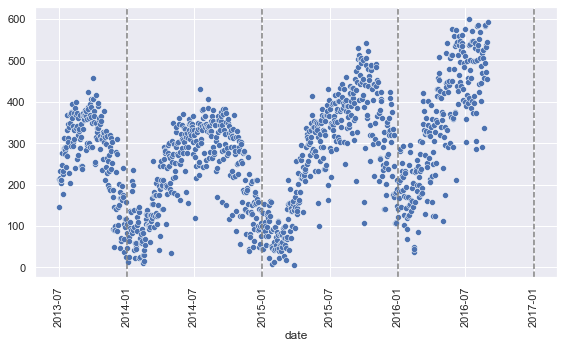

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=train.index,y=train.values, ax=ax, label='Train Data')
sns.scatterplot(x=test.index,y=test.values, ax=ax, label='Test Data')
ax.legend()
ax.tick_params(axis='x', rotation=90)
start = dt.datetime(2014, 1, 1)
ax.axvline(start, linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=1), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=2), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=3), linestyle='--', color='gray')
fig.tight_layout()

As we will see shortly why, we will need data aggregated weekly, so let's do that now, and visualize it

In [9]:
trips['Date'] = pd.to_datetime(trips['date']) - pd.to_timedelta(7, unit='d')
agg_w = trips.groupby([pd.Grouper(key='Date', freq='W-MON')]).size().sort_index()

train_w, test_w, test_weeks = utils.train_test_split(agg_w, 0.2, weekly=True)


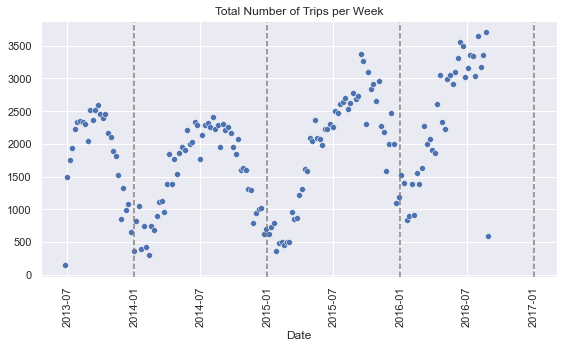

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=agg_w.index, y=agg_w.values, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_title("Total Number of Trips per Week")

start = dt.datetime(2014, 1, 1)
ax.axvline(start, linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=1), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=2), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=3), linestyle='--', color='gray')
fig.tight_layout()
fig.savefig('images/weekly_trips.png')

## Seasonal Decomposition

Before we start modelling, let's try to decompose our dataset. We can do so by spliting it into a trend, seasonality and residuals. For now, we are content with this decomposition as we will look to focus on the weekly data. However, later on we will look at a more in depth decomposition as we focus on daily data

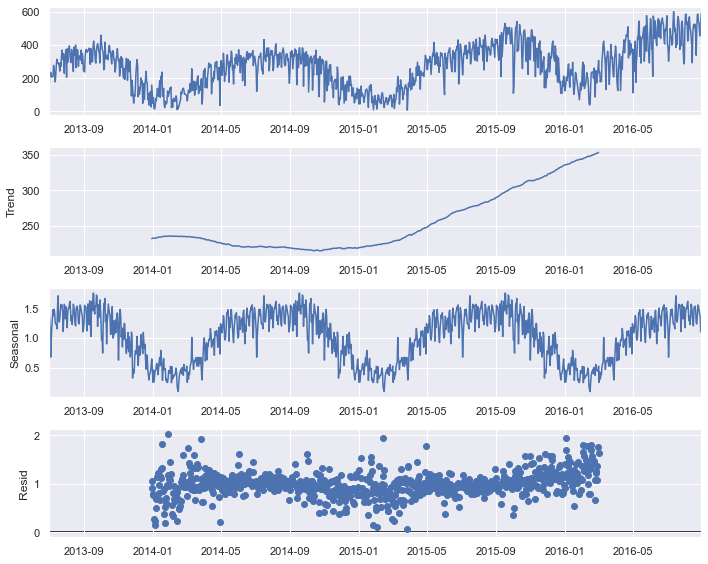

In [11]:
decomposition = seasonal_decompose(agg, 
                                   model = 'multiplicative', 
                                   period = 365)
fig = decomposition.plot();
fig.set_size_inches((10,8))
fig.tight_layout()
fig.savefig('images/decomposition.png')


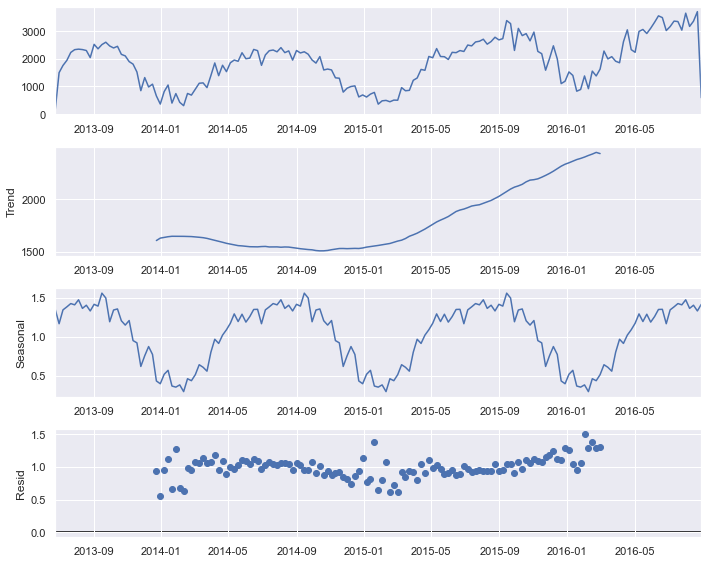

In [12]:
decomposition = seasonal_decompose(agg_w, 
                                   model = 'multiplicative', 
                                   period = 52)
fig = decomposition.plot();
fig.set_size_inches((10,8))
fig.tight_layout()
fig.savefig('images/weekly_decomposition.png')

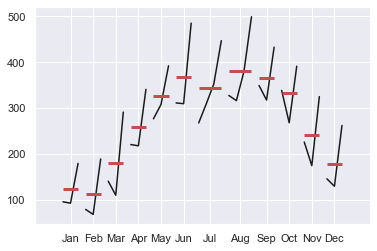

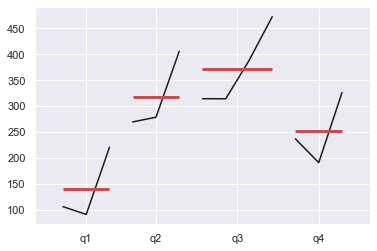

In [13]:
month_plot(agg.resample(rule = 'MS').mean());
quarter_plot(agg.resample(rule = 'Q').mean());

Ultimately, the broader pattern that we observe is that our data has an upwards trend, but only for the most recent year. From 2013-2015, we see a fairly flat trend. We also see a clear seasonal pattern where bike usage is at its highest during warm and summer months and dips down starting from the fall and lasting through the winter

## SARIMA

First, we will use SARIMA to model the time series. SARIMA really struggles to deal with daily data with a yearly seasonal trend, given that it has to look too far back for a lag. So this is why we transformed our data into weekly projections. We will first use auto arima to find out the best set of parameters for our SARIMA model

In [16]:
from pmdarima import auto_arima
model = auto_arima(y = train_w,
                   m = 52,
                   trend='ct',
                #    d=1,
                   seasonal =True,
                   stepwise = True,
                   n_job=-1,
                   random_state=42,
                   trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=1929.032, Time=2.68 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2153.995, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1930.538, Time=1.33 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2040.059, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2153.995, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=1913.783, Time=2.34 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=1917.524, Time=0.26 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=1915.945, Time=9.79 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=1922.221, Time=2.60 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=1916.113, Time=12.23 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=1927.895, Time=1.15 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=1928.279, Time=1.27 sec
 ARIMA(3,0,2)(0,0,1)[52] intercept   : AIC=1917.220, Time=2.62 sec
 ARIMA(2,0,3)(0,0,1)[52] intercept   : AIC=1920.827, Time=2.71 sec
 ARIMA(1,0,1)(0,0,

Once we find our optimal parameters, we can use our train test split to see how SARIMA performs. As seen below, the performance is sub par, even though SARIMA picks up the broader pattern, it is unable to properly predict the upwards trend. This suggests that it could be a good idea to use an algorithm that attributes more weight to more recent datapoints, like Holt Winters

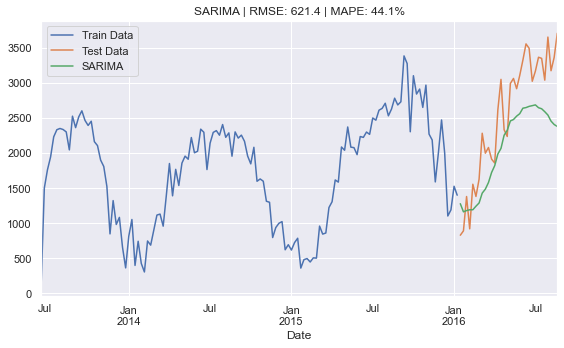

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)

sarima_pred = model.predict(n_periods= test_weeks-1)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred.index = test_w.index

sarima_rmse = mean_squared_error(test_w, sarima_pred, squared = False)
sarima_mape = utils.mape(test_w, sarima_pred)

train_w.plot(ax=ax, label='Train Data')
test_w.plot(ax=ax, label='Test Data')
sarima_pred[0].plot(ax=ax, label='SARIMA')
ax.set_title("SARIMA | RMSE: {:.1f} | MAPE: {:.1%}".format(sarima_rmse, sarima_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/sarima_pred.png')

## Holt Winters

Holt Winters uses an exponential smoothing approach that is non parametric. As it attributes more weight to more recent observation, we can see that it does a better job at picking up the more recent trend. However, when predicting daily data, we see really large, unstable fluctuations.

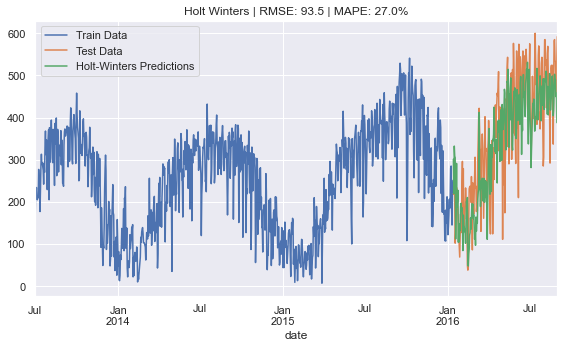

In [117]:
fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)


model = ExponentialSmoothing(endog = train,
                             trend = 'add',
                             seasonal = 'mul',
                             seasonal_periods = 365).fit()
hw_pred = model.forecast(steps = len(test)).rename("HW")
hw_rmse = mean_squared_error(test, hw_pred, squared = False)
hw_mape = utils.mape(test, hw_pred)

train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
hw_pred.plot(ax=ax, label='Holt-Winters Predictions')
ax.set_title("Holt Winters | RMSE: {:.1f} | MAPE: {:.1%}".format(hw_rmse, hw_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/holt_winters_pred.png')

So, let's try to repeat the experiment at a weekly level and see what result we obtain. From the figure below, we can see that HW does a great job at predicting weekly trend, which a much better overall accuracy than SARIMA.

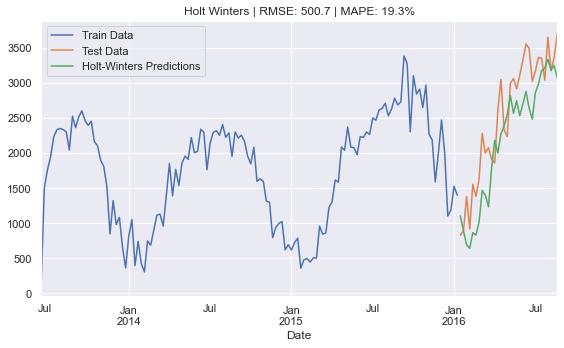

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)


model = ExponentialSmoothing(endog = train_w,
                             trend = 'add',
                             seasonal = 'mul',
                             seasonal_periods = 52).fit()
hww_pred = model.forecast(steps = len(test_w)).rename("HW")
hww_rmse = mean_squared_error(test_w, hww_pred, squared = False)
hww_mape = utils.mape(test_w, hww_pred)

train_w.plot(ax=ax, label='Train Data')
test_w.plot(ax=ax, label='Test Data')
hww_pred.plot(ax=ax, label='Holt-Winters Predictions')
ax.set_title("Holt Winters | RMSE: {:.1f} | MAPE: {:.1%}".format(hww_rmse, hww_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/holt_winters_pred_weekly.png')

## Prophet

Next, we can also use the prophet library. Prophet uses a machine learning approach towards time series, while allowing for veyr flexible adjustments to be made by the user. For now, we will not attempt to fine tune prophet but rather use an out of box solution. Later, we will attempt to fine tune it and see what performance increase we can obtain

In [196]:
df = train.reset_index().rename({'date':'ds',0:'y'},axis=1)
m = Prophet(interval_width=0.95, daily_seasonality=False)
m.fit(df)

test_prophet = pd.DataFrame(test.index).rename({'date':'ds'}, axis=1)
forecast = m.predict(test_prophet)

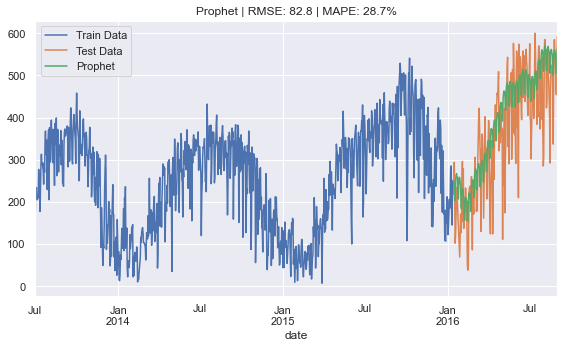

In [197]:
fig, ax = plt.subplots(figsize=(8,5)) 

prophet_pred = forecast.set_index(['ds']).loc[test.index]['yhat']
prophet_rmse = mean_squared_error(test, prophet_pred, squared = False)
prophet_mape = utils.mape(test, prophet_pred)

train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
prophet_pred.plot(ax=ax, label='Prophet')
ax.set_title("Prophet | RMSE: {:.1f} | MAPE: {:.1%}".format(prophet_rmse, prophet_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/prophet_pred.png')

Prophet observes a highly similar result as HW on the daily data. In fact, on the test data, it slightly underperform Holt Winters

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\steven.cunden\Anaconda3\envs\time_series_2\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


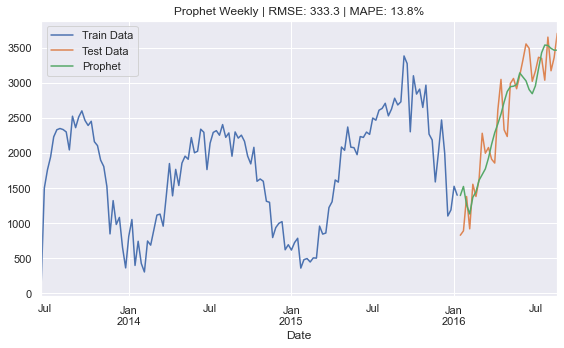

In [38]:
df_w = train_w.reset_index().rename({'Date':'ds',0:'y'},axis=1)
mw = Prophet(interval_width=0.95, daily_seasonality=False)
mw.add_country_holidays(country_name='US')
mw.fit(df_w)

test_prophet_w = pd.DataFrame(test_w.index).rename({'Date':'ds'}, axis=1)
forecast_w = mw.predict(test_prophet_w)

fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)

pw_pred = forecast_w.set_index(['ds']).loc[test_w.index]['yhat']
pw_rmse = mean_squared_error(test_w, pw_pred, squared = False)
pw_mape = utils.mape(test_w, pw_pred)

train_w.plot(ax=ax, label='Train Data')
test_w.plot(ax=ax, label='Test Data')
pw_pred.plot(ax=ax, label='Prophet')
ax.set_title("Prophet Weekly | RMSE: {:.1f} | MAPE: {:.1%}".format(pw_rmse, pw_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/prophet_pred_weekly.png')


However, it outperforms HW on the test data, but not significantly. This would suggest that prophet, like HW, is able to pick up on the most recent trend increases, which makes sense given Prophet's changepoints mechanism.

## Enssemble

Now, let's put all of our solutions together and visualize them. We can also create an enssemble for our three algorithms, that will simply average them out. Ultimately, the enssemble is not overly effective as Prophet seems to be the best performing algorithm by far, and SARIMA the worst.

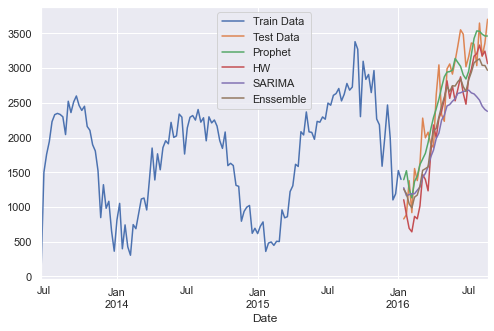

In [45]:
fig, ax = plt.subplots(figsize=(8,5)) 

train_w.plot(ax=ax, label='Train Data')
test_w.plot(ax=ax, label='Test Data')
pw_pred.plot(ax=ax, label='Prophet')
hww_pred.plot(ax=ax, label='HW')
sarima_pred[0].plot(ax=ax, label='SARIMA')

ens = pd.concat([pw_pred, hww_pred, sarima_pred[0]], axis=1).mean(axis=1)
ens.plot(ax=ax, label='Enssemble')

ax.legend()

## Model Evaluation

This can be verified by looking at the MAPE scores of each of our models, where we can see SARIMA having a really high MAPE, compared to Prophet and Holt Winters. Prophet appears to be the best performing solution.

[Text(0, 0, '44.1%'),
 Text(0, 0, '19.3%'),
 Text(0, 0, '13.8%'),
 Text(0, 0, '16.4%')]

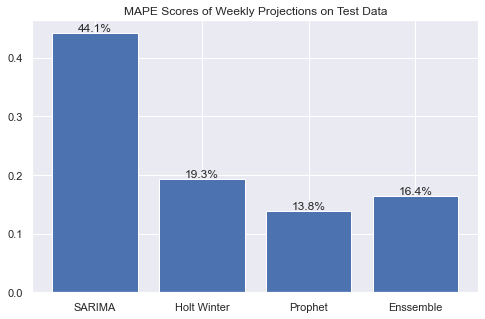

In [52]:
ens_rmse = mean_squared_error(test_w, ens, squared = False)
ens_mape = utils.mape(test_w, ens)

models = ["SARIMA","Holt Winter", "Prophet", "Enssemble"]
weekly_mape = [sarima_mape, hww_mape, pw_mape, ens_mape]
weekly_rmse = [sarima_rmse, hww_rmse, pw_rmse, ens_rmse]

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(models,weekly_mape)
ax.set_title("MAPE Scores of Weekly Projections on Test Data")
ax.bar_label(bars, labels=["{:.1%}".format(e) for e in weekly_mape])


## Projecting Weekly 2017

In [155]:

agg_wm1 = agg_w[:-1]

sarima_model = auto_arima(y = agg_wm1,
                   m = 52,
                   trend='ct',
                #    d=1,
                   seasonal =True,
                   stepwise = True,
                   n_job=-1,
                   random_state=42,
                   trace=False)

hw_model = ExponentialSmoothing(endog = agg_wm1,
                             trend = 'add',
                             seasonal = 'mul',
                             seasonal_periods = 52).fit()

df = agg_wm1.reset_index().rename({'Date':'ds',0:'y'},axis=1)
prophet_model = Prophet(interval_width=0.95, daily_seasonality=False)
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(df)
future = prophet_model.make_future_dataframe(periods=52, freq='W')
prophet_forecast = prophet_model.predict(future).tail(52)

prophet_forecast = prophet_model.predict(future).tail(52).set_index('ds').yhat
hw_forecast = hw_model.forecast(steps = 52).rename("HW")

sarima_params = sarima_model.get_params()
sarima_model_2 = sm.tsa.statespace.SARIMAX(
    agg_wm1, 
    order=sarima_params['order'],
    seasonal_order=sarima_params['seasonal_order'],
    trend='ct').fit()
sarima_pred = sarima_model_2.get_prediction(
                start=prophet_forecast.index[0],
                end=prophet_forecast.index[-1], 
                dynamic=False)
sarima_pred_ci = sarima_pred.conf_int(alpha=0.05)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


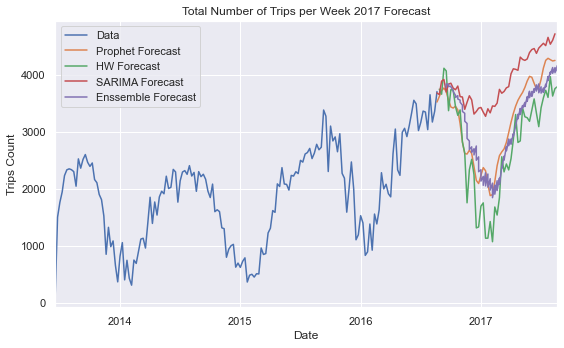

In [129]:
fig, ax = plt.subplots(figsize=(8,5)) 

agg_wm1.plot(ax=ax, label='Data')
prophet_forecast.plot(ax=ax, label='Prophet Forecast')
hw_forecast.plot(ax=ax, label='HW Forecast')
sarima_forecast.plot(ax=ax, label='SARIMA Forecast')

ens = pd.concat([prophet_forecast, hw_forecast, sarima_forecast], axis=1).mean(axis=1)
ens.rolling(7).mean().plot(label='Enssemble Forecast',ax=ax)

ax.set_title("Total Number of Trips per Week 2017 Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Trips Count")
ax.legend()

fig.tight_layout()
fig.savefig("images/2017_weekly_forecast.png")

## Fine Tuned Prophet Daily Projections

Now that we have seen Prophet outperform our other two algorithms, lets see if we can get a better performance on daily data by fine tuning some of its aspects.

In [14]:
holidays = utils.generate_holidays(agg)

In [16]:
df = agg.reset_index().rename({'date':'ds',0:'y'},axis=1)
ftp = Prophet(
    interval_width=0.95, 
    daily_seasonality=False, 
    weekly_seasonality=True, 
    holidays=holidays
    )
# ftp.add_country_holidays(country_name='US')
ftp.fit(df)

future = ftp.make_future_dataframe(periods=365)
# ftp_test = pd.DataFrame(test.index).rename({'date':'ds'}, axis=1)
ftp_forecast = ftp.predict(future)

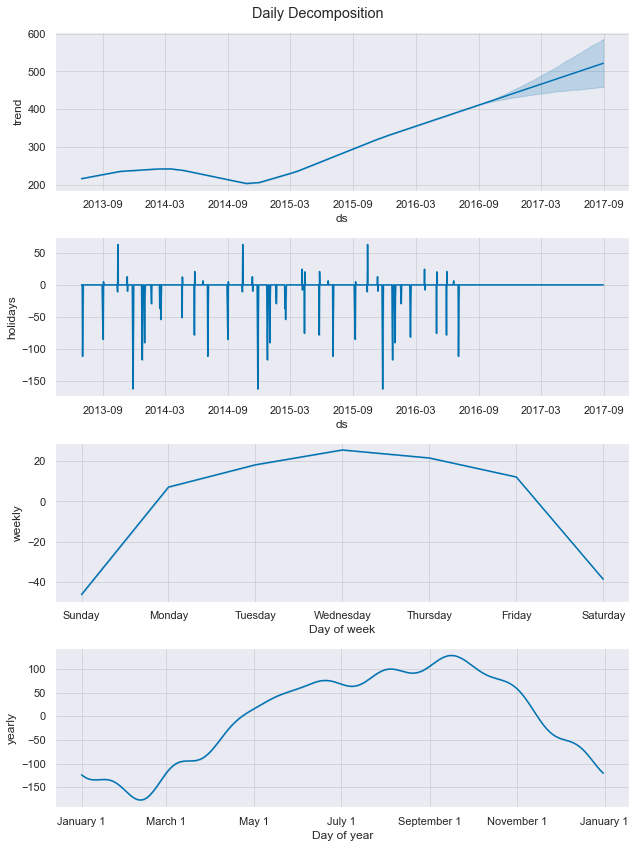

In [27]:
fig = ftp.plot_components(ftp_forecast)
fig.suptitle("Daily Decomposition")
fig.tight_layout()
fig.savefig('images/daily_decomposition.png')

In [ ]:
## Colombus day is positive and easter

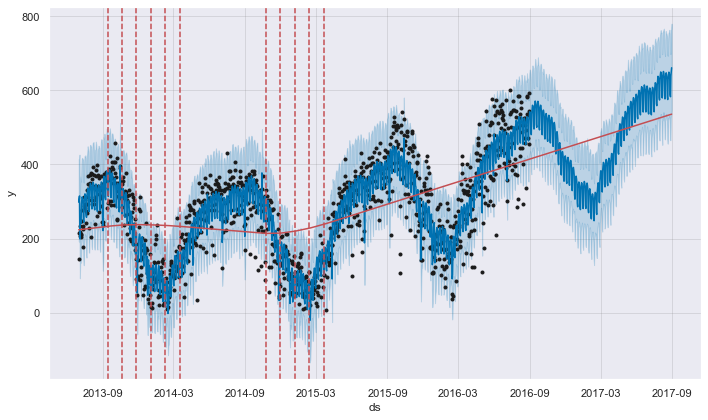

In [18]:
from prophet.plot import add_changepoints_to_plot
fig = ftp.plot(ftp_forecast)
a = add_changepoints_to_plot(fig.gca(), ftp, ftp_forecast)

In [28]:
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode':['additive', 'multiplicative'],
    'holidays':holidays
    # 'changepoint_range':[0.5,0.6,0.8,0.9]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 25 forecasts with cutoffs between 2014-07-12 00:00:00 and 2016-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002330EEDF6A0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 25 forecasts with cutoffs between 2014-07-12 00:00:00 and 2016-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002337851CB20>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 25 forecasts with cutoffs between 2014-07-12 00:00:00 and 2016-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002330503C2B0>
INFO:prophet:Disabling daily seasonality. Run prophet w

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [33]:
best_params = tuning_results.sort_values(by=['rmse']).iloc[0]
changepoint_prior_scale = best_params.changepoint_prior_scale
seasonality_prior_scale = best_params.seasonality_prior_scale
seasonality_mode = best_params.seasonality_mode

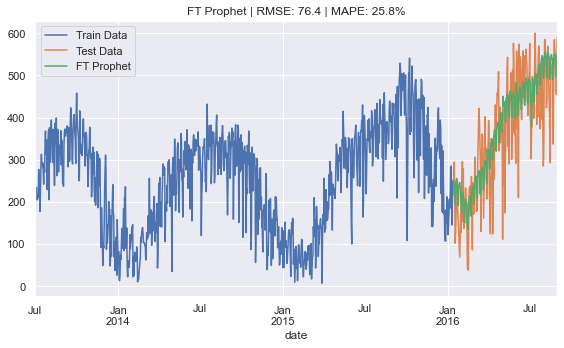

In [34]:
df = train.reset_index().rename({'date':'ds',0:'y'},axis=1)
ftp = Prophet(
    interval_width=0.95, 
    daily_seasonality=False, 
    weekly_seasonality=True, 
    changepoint_prior_scale=changepoint_prior_scale,
    seasonality_prior_scale=seasonality_prior_scale,
    seasonality_mode=seasonality_mode,
    holidays=holidays
    )
ftp.fit(df)

future = ftp.make_future_dataframe(periods=test.shape[0])
ftp_forecast = ftp.predict(future)

fig, ax = plt.subplots(figsize=(8,5)) 

ftp_pred = ftp_forecast.set_index(['ds']).loc[test.index]['yhat']
ftp_rmse = mean_squared_error(test, ftp_pred, squared = False)
ftp_mape = utils.mape(test, ftp_pred)

train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
ftp_pred.plot(ax=ax, label='FT Prophet')
ax.set_title("FT Prophet | RMSE: {:.1f} | MAPE: {:.1%}".format(ftp_rmse, ftp_mape))
ax.legend()
fig.tight_layout()
# fig.savefig('images/prophet_pred.png')

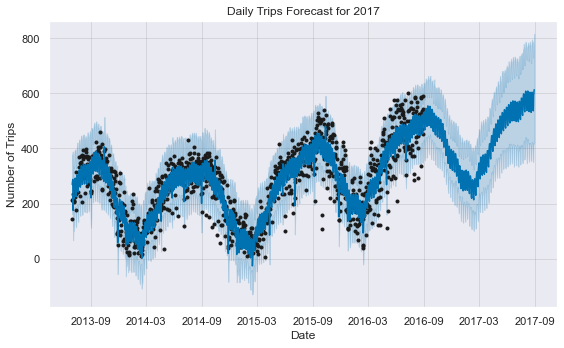

In [37]:
df = agg.reset_index().rename({'date':'ds',0:'y'},axis=1)
ftp = Prophet(
    interval_width=0.95, 
    daily_seasonality=False, 
    weekly_seasonality=True, 
    changepoint_prior_scale=changepoint_prior_scale,
    seasonality_prior_scale=seasonality_prior_scale,
    seasonality_mode=seasonality_mode,
    holidays=holidays
    )
ftp.fit(df)

future = ftp.make_future_dataframe(periods=365)
ftp_forecast = ftp.predict(future)

_, ax = plt.subplots(figsize=(8,5))
fig = ftp.plot(ftp_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Trips')
ax.set_title('Daily Trips Forecast for 2017')
fig.tight_layout()
fig.savefig('images/2017_daily_forecast.png')